<center><h1 style="color:#1a1a1a;
                    font-size:4em">
        Accident Detection
        </h1> 
        <h2 style="color:#1a1a1a;
                    font-size:3em">
        Alert the driver
        </h2>
</center>

# Problem: pick a data science problem that you plan to solve

# Loading Pakages

In [3]:
import numpy as np 
import pandas as pd 
import cv2
import seaborn as sns
import os
from tqdm import tqdm
from glob import glob
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

# Data Collection:

In [4]:
# Read the CSV file
df = pd.read_csv('driver_imgs_list.csv')
df.head(5)

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [5]:
# Group by subjects
by_drivers = df.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print('There are:', len(unique_drivers), 'unique drivers')
print('There is a mean of', round(df.groupby('subject').count()['classname'].mean()), 'images by driver.')


There are: 26 unique drivers
There is a mean of 862 images by driver.


In [10]:
num_classes = 10

In [11]:
#Read with opencv
def get_image(path, img_rows, img_cols, color_type=3):
    
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

#Loading training dataset
def train_data_load(img_rows=64, img_cols=64, color_type=3):
    train_images=[]
    train_labels=[]
    
    #Loop over the training folder
    for classes in tqdm(range(num_classes)):
        print('Loading directory c{}'.format(classes))
        files = glob(os.path.join('/path/to/destination/folder' + str(classes), '*.jpg'))
        for file in files:
            img = get_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classes)
    return train_images, train_labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = train_data_load(img_rows, img_cols, color_type)
    #y = np_utils.to_categorical(labels, 10)
    y = to_categorical(labels, 10)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

#Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('/path/to/destination/folder', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids
    

In [69]:
img_rows = 64
img_cols = 64
color_type = 1
nb_test_samples = 200

#Loading train images 
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

#Loading validation images 
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:28<04:14, 28.31s/it]

Loading directory c1


 20%|██        | 2/10 [00:54<03:34, 26.82s/it]

Loading directory c2


 30%|███       | 3/10 [01:14<02:46, 23.82s/it]

Loading directory c3


 40%|████      | 4/10 [01:36<02:19, 23.32s/it]

Loading directory c4


 50%|█████     | 5/10 [02:00<01:57, 23.50s/it]

Loading directory c5


 60%|██████    | 6/10 [02:24<01:34, 23.50s/it]

Loading directory c6


 70%|███████   | 7/10 [02:46<01:09, 23.24s/it]

Loading directory c7


 80%|████████  | 8/10 [03:05<00:43, 21.78s/it]

Loading directory c8


 90%|█████████ | 9/10 [03:23<00:20, 20.58s/it]

Loading directory c9


  0%|          | 200/79726 [00:01<12:30, 105.93it/s]


<div id="overview">
        <h1 style="color:#1a1a1a">
         Data Exploration: Exploring the Dataset
        </h1>
</div>

## Data visualisation
 

In [6]:
import plotly.express as px
px.histogram(df, x="classname", color="classname", title="Number of images by categories ")


In [8]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((df['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

In [7]:
# Basic statistics about the dataset
print("\nBasic statistics about the dataset:")
print(df.describe())


Basic statistics about the dataset:
       subject classname            img
count    22424     22424          22424
unique      26        10          22424
top       p021        c0  img_44733.jpg
freq      1237      2489              1


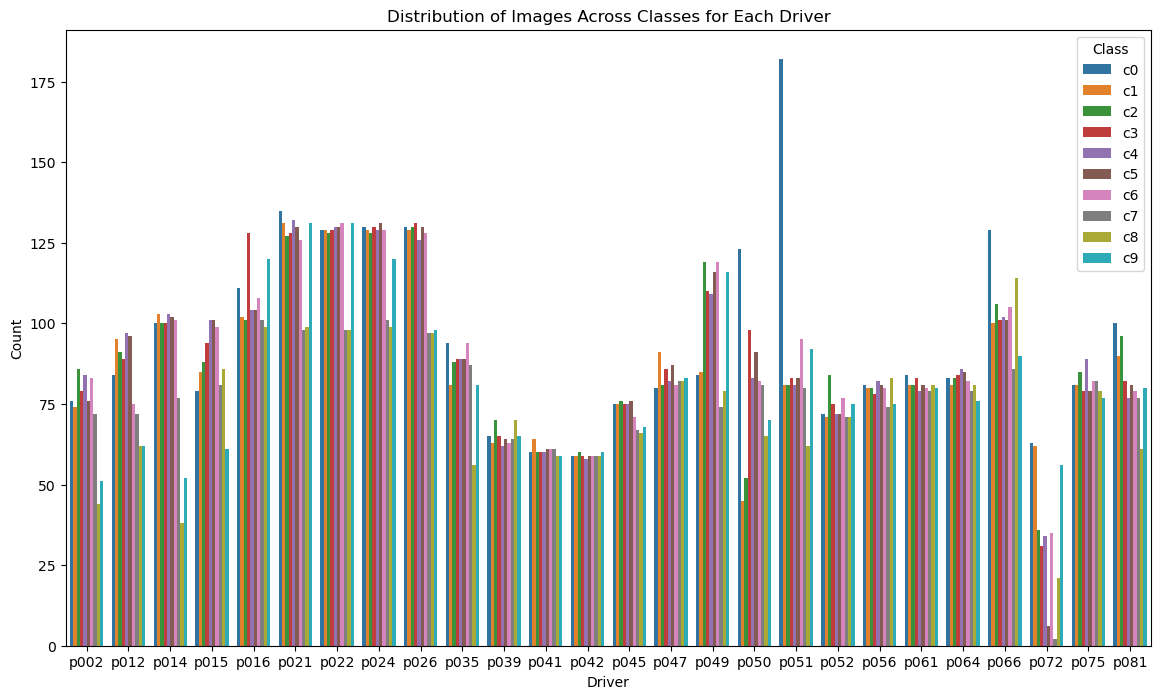

In [18]:
# Distribution of images across classes for each driver
plt.figure(figsize=(14, 8))
sns.countplot(x='subject', hue='classname', data=df)
plt.title('Distribution of Images Across Classes for Each Driver')
plt.xlabel('Driver')
plt.ylabel('Count')
plt.legend(title='Class')
plt.show()


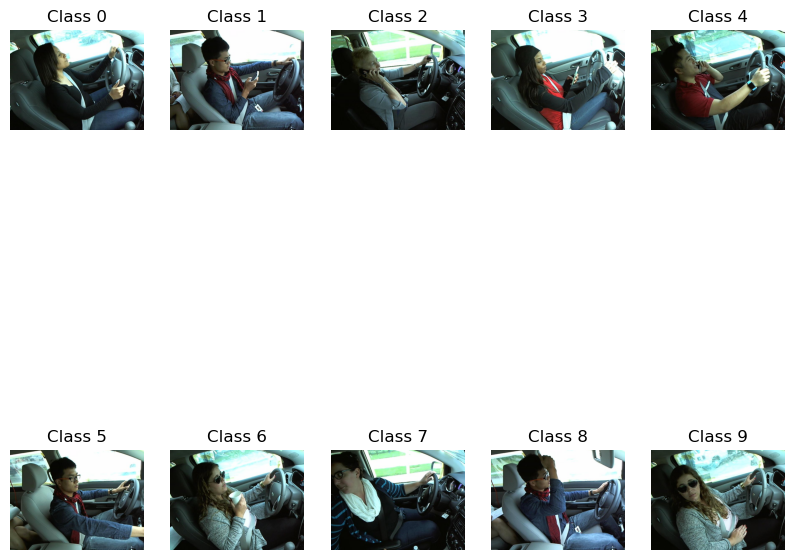

In [30]:
# Visualize sample images from each class
plt.figure(figsize=(10, 10))
for i in range(num_classes):
    class_images = df[df['classname'] == 'c' + str(i)]
    sample_image = class_images.sample(1)['img'].values[0]
    img = mpimg.imread('/path/to/destination/folder' + str(i) + '/' + sample_image)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title('Class {}'.format(i))
    plt.axis('off')
plt.show()


## Images overview


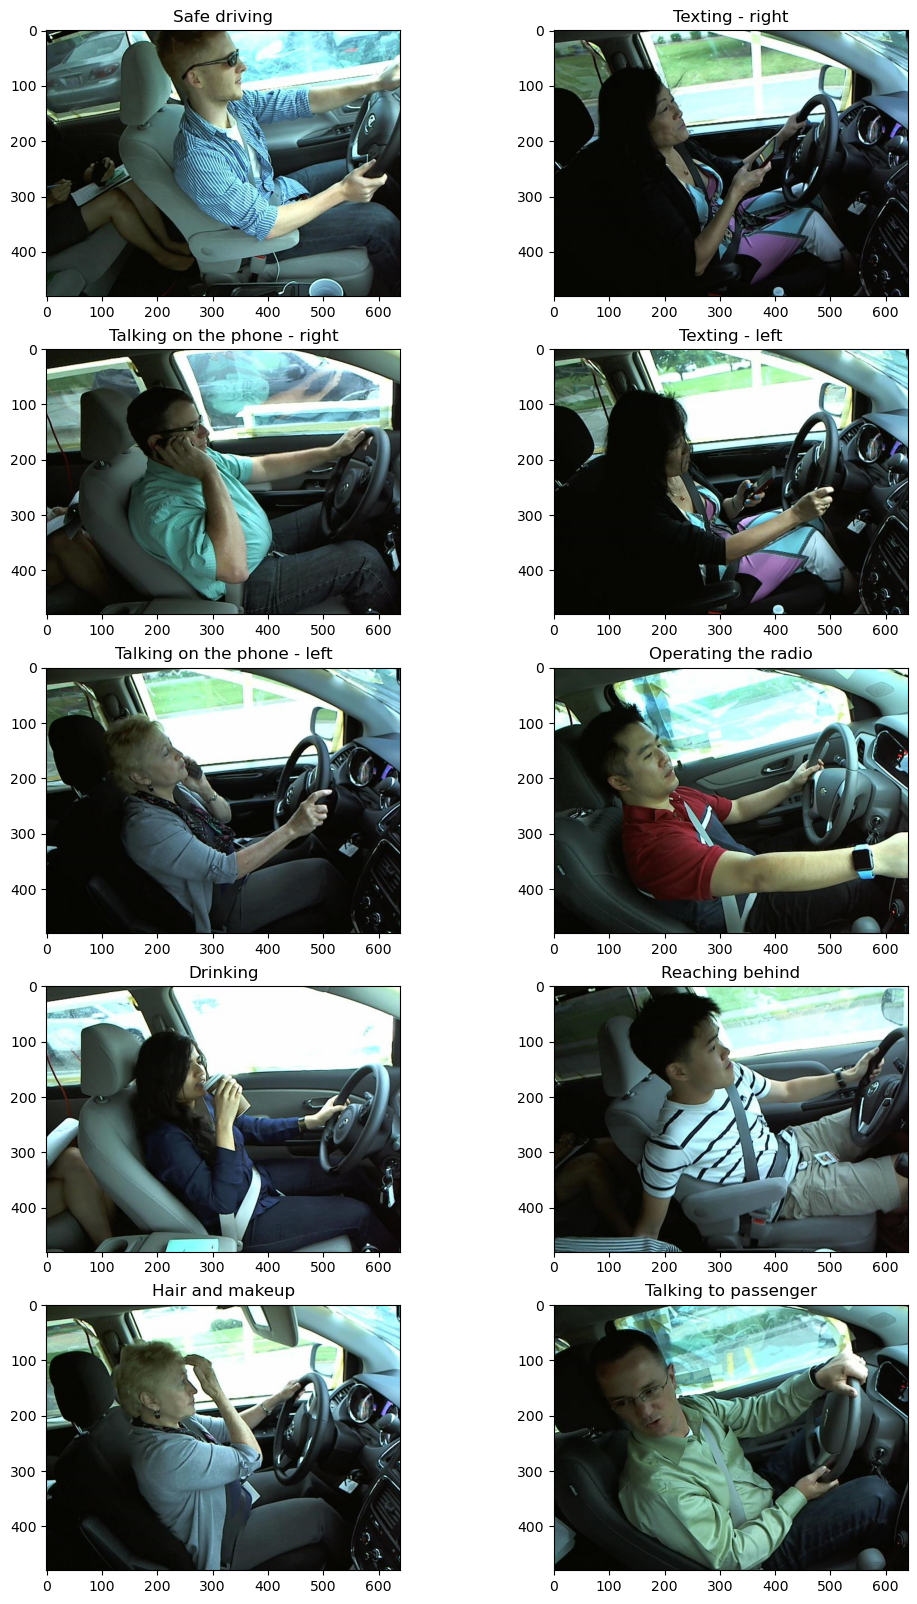

In [72]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/path/to/destination/folder'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

# Data Analysis:  Different methods and models to solve the problem you proposed, and find out the best solution.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.utils import to_categorical


df = pd.read_csv('driver_imgs_list.csv', nrows=1000)

num_classes = 10

# Read with OpenCV
def get_image(path, img_rows, img_cols, color_type=3):
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols))  # Reduce size
    return img

# Loading training dataset
def train_data_load(img_rows=64, img_cols=64, color_type=3):
    train_images = []
    train_labels = []
    
    
    for classes in tqdm(range(num_classes)):
        print('Loading directory c{}'.format(classes))
        files = glob(os.path.join('/path/to/destination/folder' + str(classes), '*.jpg'))
        for file in files[:1000]:  # Load only the first 1000 images per class
            img = get_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classes)
    return train_images, train_labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = train_data_load(img_rows, img_cols, color_type)
    y = np.array(labels)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.8, random_state=42)
    X_train = np.array(X_train, dtype=np.uint8).reshape(-1, img_rows * img_cols * color_type)
    y_train = np.array(y_train)
    return X_train, y_train

# Load the training data
img_rows = 64
img_cols = 64
color_type = 1
X_train, y_train = read_and_normalize_train_data(img_rows, img_cols, color_type)

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

# Add CNN model to the dictionary of models
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = (img_rows, img_cols, color_type)
cnn_model = create_cnn_model(input_shape, num_classes)
models['CNN'] = cnn_model

# Train the models
for name, model in models.items():
    if name == 'CNN':
        # Reshape input for CNN model
        X_train_cnn = np.array(X_train).reshape(-1, img_rows, img_cols, color_type)
        # Convert labels to one-hot encoding for CNN model
        y_train_cnn = to_categorical(y_train, num_classes=num_classes)
        model.fit(X_train_cnn, y_train_cnn, epochs=9, batch_size=32, validation_split=0.2, verbose=1)
    else:
        model.fit(X_train, y_train)

# Print a message to indicate the end of training
print("Training completed!")


  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:09<01:23,  9.25s/it]

Loading directory c1


 20%|██        | 2/10 [00:18<01:14,  9.26s/it]

Loading directory c2


 30%|███       | 3/10 [00:26<01:02,  8.90s/it]

Loading directory c3


 40%|████      | 4/10 [00:35<00:53,  8.85s/it]

Loading directory c4


 50%|█████     | 5/10 [00:44<00:44,  8.86s/it]

Loading directory c5


 60%|██████    | 6/10 [00:52<00:34,  8.69s/it]

Loading directory c6


 70%|███████   | 7/10 [01:03<00:27,  9.21s/it]

Loading directory c7


 80%|████████  | 8/10 [01:11<00:17,  8.91s/it]

Loading directory c8


 90%|█████████ | 9/10 [01:20<00:08,  8.81s/it]

Loading directory c9


100%|██████████| 10/10 [01:29<00:00,  8.93s/it]
C:\Users\patil\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

C:\Users\patil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.1490 - loss: 38.8345 - val_accuracy: 0.4350 - val_loss: 1.7869
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4448 - loss: 1.6537 - val_accuracy: 0.6475 - val_loss: 1.1257
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6849 - loss: 0.9929 - val_accuracy: 0.7825 - val_loss: 0.5899
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7762 - loss: 0.6694 - val_accuracy: 0.7950 - val_loss: 0.5423
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8407 - loss: 0.4584 - val_accuracy: 0.8950 - val_loss: 0.3455
Training completed!


# Models comparisons

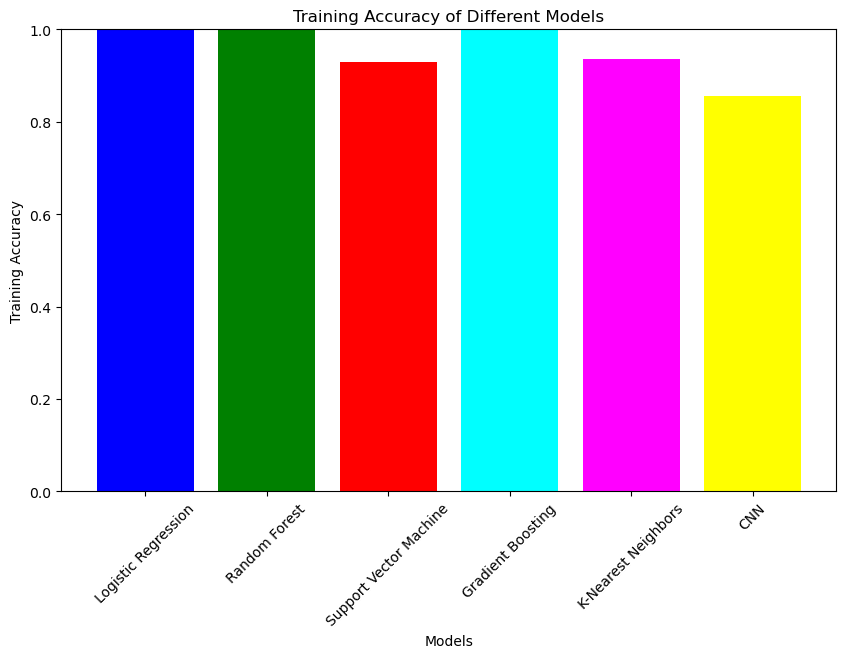

In [11]:
import matplotlib.pyplot as plt

# Get the training accuracies for all models
train_accuracies = {}

for name, model in models.items():
    if name == 'CNN':
        # For CNN model, get the training accuracy from the history object
        train_accuracies[name] = max(model.history.history['accuracy'])
    else:
        # For other models, use the score method to get the training accuracy
        train_accuracies[name] = model.score(X_train, y_train)

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(train_accuracies.keys(), train_accuracies.values(), color=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])
plt.xlabel('Models')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy of Different Models')
plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


<div id="overview">
        <h1 style="color:#1a1a1a">
         CNN Model 
        </h1>
</div>

### Architecture :

* 3 Convolutionnal layers (with Relu, Maxpooling and dropout)
* A flatten layer
* 2 Dense layers with Relu and Dropouts
* 1 Dense layer with softmax for the classification

In [73]:
batch_size = 40
n_epochs = 10

In [74]:
def create_model():
    
    model = Sequential()
    
    # CNN1
    model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(img_rows, img_cols, color_type), padding='same'))
    model.add(BatchNormalization())
    # CNN2
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # CNN3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    # CNN4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening followed by Dense layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))  # Assuming 10 classes for classification

    return model

In [75]:
model = create_model()

#Details about the model
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\patil\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │    67,109,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,947,338 (263.01 MB)

 Trainable params: 68,942,730 (263.00 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [76]:
history = model.fit(x_train, y_train,
                   validation_data=(x_test, y_test),
                   epochs=n_epochs, batch_size=batch_size, verbose=1)

print('History of the training',history.history)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1650s 4s/step - accuracy: 0.4879 - loss: 1.8722 - val_accuracy: 0.8426 - val_loss: 0.5769
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 3518s 8s/step - accuracy: 0.9334 - loss: 0.2074 - val_accuracy: 0.9679 - val_loss: 0.1011
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1713s 4s/step - accuracy: 0.9697 - loss: 0.0953 - val_accuracy: 0.9777 - val_loss: 0.0825
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1592s 4s/step - accuracy: 0.9825 - loss: 0.0570 - val_accuracy: 0.9064 - val_loss: 0.2880
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1591s 4s/step - accuracy: 0.9853 - loss: 0.0444 - val_accuracy: 0.9545 - val_loss: 0.1627
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1595s 4s/step - accuracy: 0.9880 - loss: 0.0411 - val_accuracy: 0.9652 - val_loss: 0.1196
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1707s 4s/step - accuracy: 0.9911 - loss: 0.0259 - val_accuracy: 0.9897 - val_loss: 0.0379
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 2114s 5s/step - accuracy: 0.9921 - loss: 0.0260 - 

#### Training model

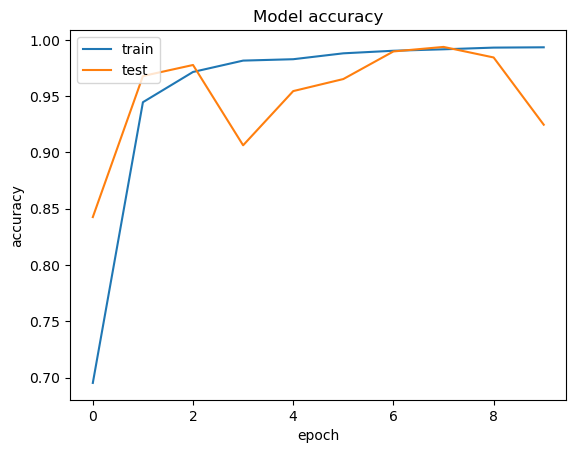

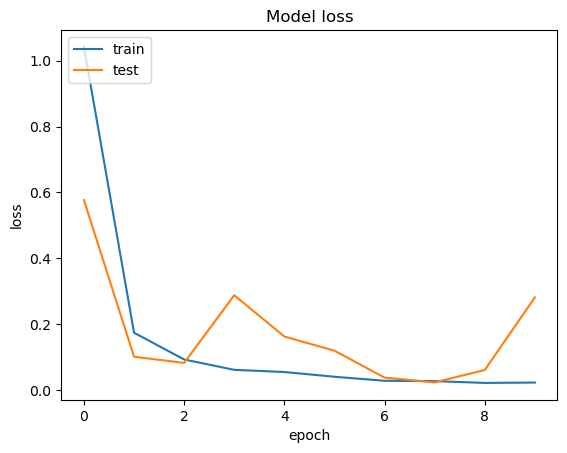

In [77]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_train_history(history)

### Prediction on test set

In [78]:
def plot_test_class(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [79]:
score1 = model.evaluate(x_test, y_test, verbose=1)


141/141 ━━━━━━━━━━━━━━━━━━━━ 97s 688ms/step - accuracy: 0.9295 - loss: 0.2527


In [80]:
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

Loss:  0.2814938426017761
Accuracy:  92.46376752853394  %


# Testing model on  worst case sample dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
Y prediction: [[6.0162074e-14 6.3435881e-19 2.8848229e-15 3.9340856e-15 1.3586849e-14
  1.0000000e+00 2.0544983e-15 1.7889817e-14 5.6480097e-17 1.0857979e-12]]
Predicted: Operating the radio


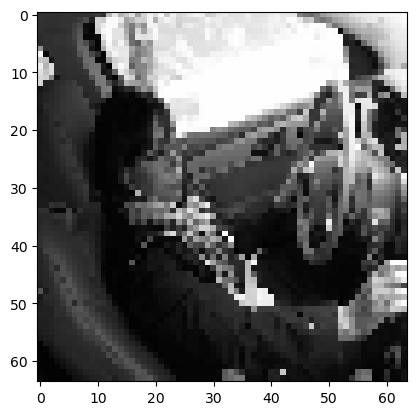

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Y prediction: [[3.6021333e-12 3.3231369e-14 4.4771470e-10 7.3923595e-10 2.7864422e-10
  1.0000000e+00 1.9768269e-09 9.9284136e-11 4.1530206e-11 5.4178850e-10]]
Predicted: Operating the radio


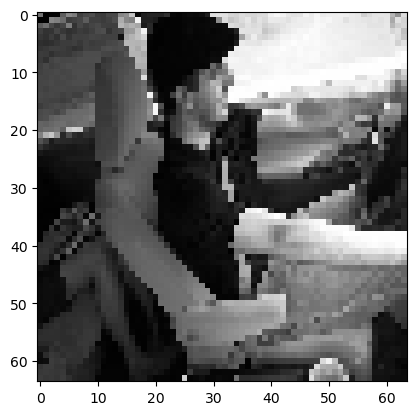

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Y prediction: [[1.2299987e-01 2.2253627e-05 3.0191075e-05 1.0941065e-05 3.1076320e-06
  8.7912966e-05 9.5348518e-08 3.9478508e-04 7.0261922e-07 8.7645018e-01]]
Predicted: Talking to passenger


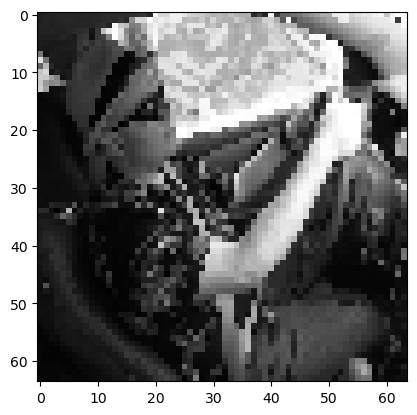

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Y prediction: [[1.1862229e-04 3.1330334e-08 7.4843476e-05 2.4127025e-06 9.7937208e-01
  2.3326158e-04 1.5873554e-04 1.3640041e-03 1.8592453e-02 8.3493847e-05]]
Predicted: Talking on the phone - left


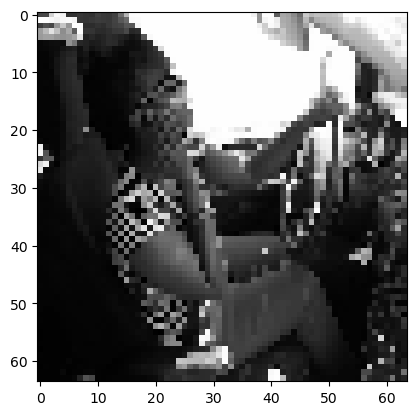

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Y prediction: [[6.43879903e-05 1.22289566e-11 3.49523179e-06 3.05027044e-08
  8.38887751e-01 1.57403931e-01 3.53442796e-04 8.37769942e-09
  9.99339591e-06 3.27699445e-03]]
Predicted: Talking on the phone - left


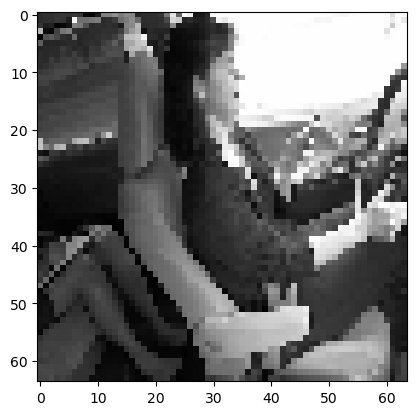

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Y prediction: [[5.8854719e-05 1.9233523e-08 1.3320664e-08 4.0342700e-05 9.8927373e-01
  9.7494842e-03 3.8741049e-08 8.7247655e-04 4.0090576e-06 1.1045630e-06]]
Predicted: Talking on the phone - left


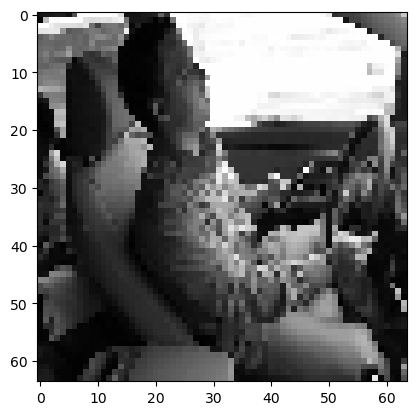

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Y prediction: [[1.4816409e-04 1.0987774e-04 7.7446122e-05 9.8789670e-04 1.8225612e-01
  1.4231715e-01 1.6971130e-02 6.2676889e-01 3.4116243e-03 2.6951764e-02]]
Predicted: Reaching behind


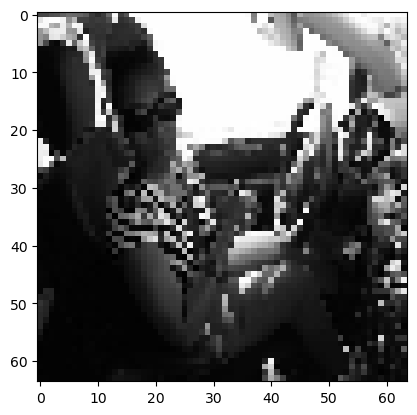

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Y prediction: [[3.0208574e-04 3.1036168e-07 1.2889464e-01 2.3590244e-06 4.3289261e-03
  5.6929584e-03 4.4964669e-05 2.1712488e-01 3.4724344e-03 6.4013642e-01]]
Predicted: Talking to passenger


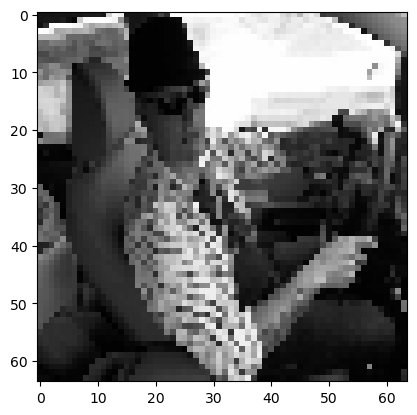

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Y prediction: [[9.8833858e-11 4.0898782e-12 2.0410491e-05 5.0847515e-13 3.2493233e-07
  5.1483369e-07 9.9997866e-01 3.7028891e-09 1.8795330e-07 1.6032393e-08]]
Predicted: Drinking


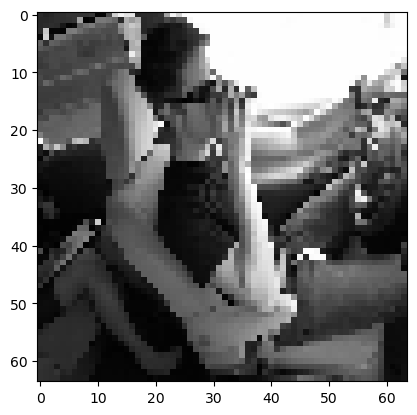

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Y prediction: [[2.9052585e-09 1.6054204e-07 1.0274028e-06 1.9968274e-11 9.8935298e-06
  3.1164226e-03 2.8891354e-06 9.9684119e-01 2.8207112e-05 1.6591090e-07]]
Predicted: Reaching behind


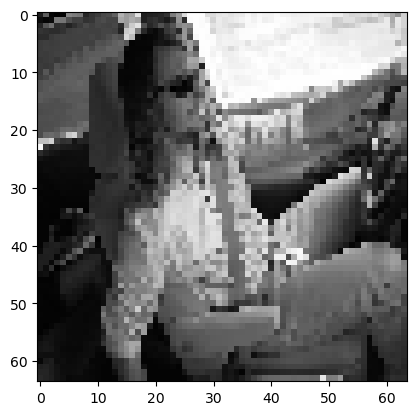

In [81]:
for i in range(10):
    plot_test_class(model, test_files, i)

<div id="overview">
        <h1 style="color:#1a1a1a">
         ⮞  Part 4 : Data Augmentation
        </h1>
</div>

In [89]:
# Using ImageDataGenerator from keras
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [90]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

### Training with data augmentation

In [92]:
history_v2 = model.fit(training_generator,
                      epochs=n_epochs,
                      validation_data=validation_generator,
                      steps_per_epoch=nb_train_samples // batch_size,
                      validation_steps=nb_validation_samples // batch_size,
                      verbose=1)

Epoch 1/10


C:\Users\patil\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



448/448 ━━━━━━━━━━━━━━━━━━━━ 1599s 4s/step - accuracy: 0.6405 - loss: 1.7810 - val_accuracy: 0.1040 - val_loss: 47.3599
Epoch 2/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 26:07 4s/step - accuracy: 0.9250 - loss: 0.2099

C:\Users\patil\anaconda3\Lib\contextlib.py:155: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 926us/step - accuracy: 0.9250 - loss: 0.2099 - val_accuracy: 0.0000e+00 - val_loss: 49.3229
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1580s 4s/step - accuracy: 0.8707 - loss: 0.4199 - val_accuracy: 0.6304 - val_loss: 2.9282
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 928us/step - accuracy: 0.9250 - loss: 0.2333 - val_accuracy: 1.0000 - val_loss: 0.0478
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1588s 4s/step - accuracy: 0.9241 - loss: 0.2394 - val_accuracy: 0.9893 - val_loss: 0.0407
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8750 - loss: 0.2895 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1580s 4s/step - accuracy: 0.9453 - loss: 0.1819 - val_accuracy: 0.9886 - val_loss: 0.0403
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9750 - loss: 0.0749 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1583s 4s/step - accuracy: 0.9497 - loss: 0.1634 - val_accura

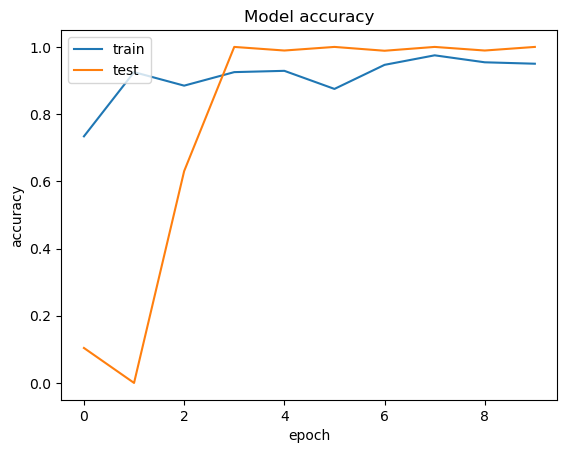

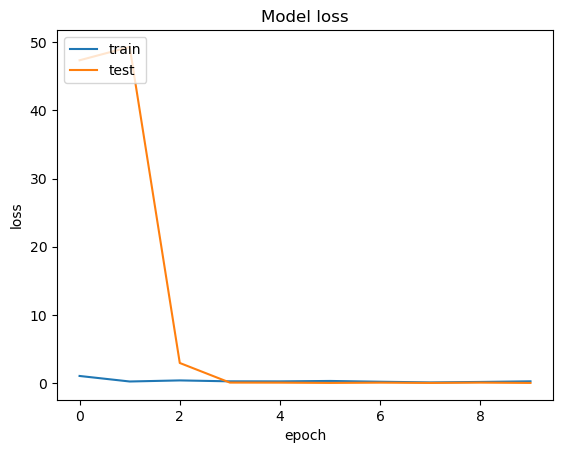

In [93]:
plot_train_history(history_v2)


# After model traininng and testing completed we save our model to .keras file

In [101]:
# Save the model to a file
model.save('model.keras')

In [102]:
# Load the model from the file
from keras.models import load_model

model = load_model('model.keras')

# .keras file is not good with image dataset we move to .h5 model and save our model to .h5 file

In [116]:
# Save the entire model
model.save('model.h5')

In [117]:
from tensorflow.keras.models import load_model

loaded_model = load_model('model.h5')

In [119]:
print(model)

<Sequential name=sequential_1, built=True>


In [120]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │    67,109,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,890,070 (526.01 MB)

 Trainable params: 68,942,730 (263.00 MB)

 Non-trainable params: 4,608 (18.00 KB)

 Optimizer params: 68,942,732 (263.00 MB)

# load saved model file

In [121]:
from tensorflow.keras.models import save_model

save_model(model, 'model.h5')

# Final Result

In [ ]:
!pip install opencv-python

In [ ]:
from keras.models import load_model
from PIL import Image, ImageTk
from tkinter import filedialog
import tkinter as tk
import numpy as np
import time
import cv2
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

class App:
    def __init__(self, window, window_title):        
        # Load the trained model
        self.model = load_model('model.h5')
        
        # Define the image dimensions
        self.img_rows = 64
        self.img_cols = 64
        
        # Create a transparent image
        transparent_image = Image.new('RGBA', (100, 100), (0, 0, 0, 0))
        transparent_photo = ImageTk.PhotoImage(transparent_image)

        # Define the activity map
        self.activity_map = {
            'c0': 'Safe driving', 
            'c1': 'Texting - right', 
            'c2': 'Talking on the phone - right', 
            'c3': 'Texting - left', 
            'c4': 'Talking on the phone - left', 
            'c5': 'Operating the radio', 
            'c6': 'Drinking', 
            'c7': 'Reaching behind', 
            'c8': 'Hair and makeup', 
            'c9': 'Talking to passenger'
        }
        
        self.window = window
        self.window.title(window_title)
        
        # Set background image
        bg_image = Image.open('a.jpeg').resize((window.winfo_screenwidth(), window.winfo_screenheight()))
        self.bg_image = ImageTk.PhotoImage(bg_image)  # Keep a reference to prevent garbage collection
        bg_label = tk.Label(window, image=self.bg_image)
        bg_label.place(x=0, y=0, relwidth=1, relheight=1)

        # Get screen width and height
        screen_width = self.window.winfo_screenwidth()
        screen_height = self.window.winfo_screenheight()

        # Set window size to match screen resolution
        self.window.geometry(f"{screen_width}x{screen_height}")

        self.video_source = 0  # Use the default webcam
        self.vid = cv2.VideoCapture(self.video_source)

        self.canvas_video = tk.Canvas(window, width=screen_width // 2, height=screen_height // 2)
        self.canvas_video.grid(row=0, column=0, padx=5, pady=5)

        self.canvas_frame = tk.Canvas(window, width=screen_width // 2, height=screen_height // 2)
        self.canvas_frame.grid(row=0, column=1)

        self.canvas_graph = tk.Canvas(window, width=screen_width // 2, height=screen_height)
        self.canvas_graph.grid(row=3, column=0, padx=5, pady=5)

        self.btn_start_stop = tk.Button(window, text="Start Recording", width=20, command=self.toggle_recording)
        self.btn_start_stop.grid(row=1, column=0, padx=5, pady=5)
        
        self.btn_upload_image = tk.Button(window, text="Upload Image", width=20, command=self.upload_image)
        self.btn_upload_image.grid(row=1, column=1, padx=5, pady=5)

        # Create a frame to hold the predicted label and statistics
        self.info_frame = tk.Frame(window)
        self.info_frame.grid(row=3, column=1, padx=15, pady=5)

        self.label_prediction = tk.Label(self.info_frame, text="Predicted Label:", font=("Helvetica", 20), fg="red")
        self.label_prediction.pack(pady=(0, 10))

        self.stats_label = tk.Label(self.info_frame, text="Statistics:", font=("Helvetica", 14))
        self.stats_label.pack(pady=(5, 0))
        
        # Initialize graph
        self.class_labels = [f'c{i}' for i in range(10)]
        self.class_freq = [0] * 10
        self.fig, self.ax = plt.subplots()
        self.ax.bar(self.class_labels, self.class_freq)
        self.ax.set_xlabel('Class')
        self.ax.set_ylabel('Frequency')
        self.ax.set_title('Class Frequency')
        self.canvas_graph = FigureCanvasTkAgg(self.fig, master=self.canvas_graph)
        self.canvas_graph.get_tk_widget().config(width=800, height=260)
        self.canvas_graph.get_tk_widget().pack()


        self.recording = False
        self.last_capture_time = time.time()
        self.start_time = 0
        self.total_frames = 0
        self.driver_score = 0
        
        # self.stats_label = tk.Label(window, text="Statistics:")
        # self.stats_label.grid(row=3, column=1, padx=15, pady=5)

        self.update()
        self.window.mainloop()

    def toggle_recording(self):
        if not self.recording:
            self.start_time = time.time()
            self.total_frames = 0
            self.driver_score = 0
            self.update_graph(reset=True)
        self.recording = not self.recording
        self.btn_start_stop.config(text="Stop Recording" if self.recording else "Start Recording")

    def upload_image(self):
        if self.recording:
            self.toggle_recording()
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")])
        if file_path:
            img = Image.open(file_path)
            self.display_frame(self.canvas_frame, img, is_uploaded_image=True)  # Use display_frame to show the uploaded image
            img = img.convert('L') 
            img = img.resize((self.img_rows, self.img_cols))  # Resize the image to match the model's input shape
            img = np.array(img)
            img = img / 255.0  
            img = np.expand_dims(img, axis=0)
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            pred = self.model.predict(img)
            predicted_class = np.argmax(pred)
            predicted_activity = self.activity_map['c' + str(predicted_class)]
            self.label_prediction.config(text=f'Predicted class: {predicted_activity}')
            self.refresh_stats()

    def update(self):
        ret, frame = self.vid.read()
        if ret:
            self.display_frame(self.canvas_video, frame)
            current_time = time.time()
            if self.recording and current_time - self.last_capture_time >= 2:
                self.last_capture_time = current_time
                self.display_frame(self.canvas_frame, frame)
                # Classify the frame (dummy function for now)
                predicted_label = self.classify_frame(frame)
                predicted_activity = self.activity_map['c' + str(predicted_label)]
                self.label_prediction.config(text=f'Predicted class: {predicted_activity}')
                self.total_frames += 1                    
                self.update_graph(predicted_label)
                self.update_stats(current_time)

        self.window.after(10, self.update)

        
    def display_frame(self, canvas, frame_or_img, is_uploaded_image=False):
        canvas_width = canvas.winfo_width()
        canvas_height = canvas.winfo_height()
        if is_uploaded_image:  # If it's an uploaded image
            photo = ImageTk.PhotoImage(frame_or_img.resize((canvas_width, canvas_height)))
        else:  # If it's a frame from webcam
            frame = cv2.cvtColor(frame_or_img, cv2.COLOR_BGR2RGB)
            photo = ImageTk.PhotoImage(image=Image.fromarray(frame).resize((canvas_width, canvas_height)))
        canvas.img = photo  # Store the PhotoImage object in the canvas widget
        canvas.create_image(0, 0, image=photo, anchor=tk.NW)


    def classify_frame(self, frame):
        # Convert the frame to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize the frame to match the input size expected by the model
        resized_frame = cv2.resize(frame_gray, (self.img_rows, self.img_cols))

        # Normalize the frame
        resized_frame = resized_frame / 255.0

        # Expand the dimensions of the frame to match the input shape expected by the model
        input_frame = np.expand_dims(resized_frame, axis=0)
        input_frame = np.expand_dims(input_frame, axis=-1)  # Add channel dimension

        # Make a prediction using the model
        pred = self.model.predict(input_frame)
        predicted_class = np.argmax(pred)
        self.driver_score += pred[0, predicted_class]  # Update driver score
        return predicted_class
        
    def update_graph(self, predicted_label=None, reset=False):
        class_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'teal', 'pink']
        if reset:
            self.class_freq = [0] * 10  # Reset class frequency to 0
        elif predicted_label is not None:
            self.class_freq[predicted_label] += 1
        
        self.ax.clear()
        for i, (label, freq) in enumerate(zip(self.class_labels, self.class_freq)):
            color = class_colors[i % len(class_colors)]  # Cycle through colors
            self.ax.bar(label, freq, color=color)        
            
        self.ax.set_xlabel('Class')
        self.ax.set_ylabel('Frequency')
        self.ax.set_title('Class Frequency')
        self.canvas_graph.draw()


    def update_stats(self, current_time):
        recording_time = current_time - self.start_time
        self.stats_label.config(text=f"Recording Time: {recording_time:.2f}s\nTotal Frames: {self.total_frames}\nDriver Score: {self.driver_score}")

    def refresh_stats(self):
        self.stats_label.config(text="")

    
    def __del__(self):
        if self.vid.isOpened():
            self.vid.release()

# Create a window and pass it to the App class
App(tk.Tk(), "Driver Behavior Analysis")
